In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import folium
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyo
import nbformat


plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from IPython.display import display

In [126]:
race = 'data/my_route_csv/Bull_Run_50M_2018.csv'
df = pd.read_csv('data/df_mtv2loop.csv')
df.describe()

,latitude,longitude,elevation,distance,mph,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,step_feet,moving_time
count,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000
mean,38.776891,-77.057857,-3.665892,0.001926,6.932480,599.728588,-0.004275,-0.665892,4.156972,2151.500000,10.167637,0.995586
std,0.008550,0.006189,17.281843,0.000440,1.584471,924.760747,0.222090,17.281843,2.303595,1242.602108,2.323891,0.066303
min,38.766160,-77.065959,-27.200001,0.000000,0.000000,0.000000,-1.200000,-24.200001,0.000000,0.000000,0.000000,0.000000
25%,38.770136,-77.063445,-18.600000,0.001673,6.024303,448.238032,-0.199999,-15.600000,2.320818,1075.750000,8.835644,1.000000
50%,38.774916,-77.060646,-6.600000,0.002023,7.282188,494.331257,0.000000,-3.600000,4.153441,2151.500000,10.680542,1.000000
75%,38.782989,-77.052164,12.800000,0.002231,8.030961,597.467931,0.199999,15.800000,6.047302,3227.250000,11.778743,1.000000
max,38.796494,-77.045499,28.400000,0.002777,9.995904,42372.881356,2.000000,31.400000,8.288165,4303.000000,14.660659,1.000000


In [127]:
df.tail()

,time,latitude,longitude,elevation,pointxyz,distance,mph,pace,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time
4299,2021-11-19 16:04:32+00:00,38.795236,-77.045685,-21.6,"(38.7952355761081, -77.04568499699235, -21.600...",0.002137,7.694640,0:07:47.858145,467.858145,0.000000,-18.6,8.280211,4299,1:11:39,11.285472,1
4300,2021-11-19 16:04:33+00:00,38.795267,-77.045679,-21.6,"(38.79526692442596, -77.04567896202207, -21.60...",0.002190,7.884756,0:07:36.577223,456.577223,0.000000,-18.6,8.282401,4300,1:11:40,11.564309,1
4301,2021-11-19 16:04:34+00:00,38.795301,-77.045674,-21.6,"(38.79530120640993, -77.04567359760404, -21.60...",0.002386,8.590356,0:06:59.074599,419.074599,0.000000,-18.6,8.284787,4301,1:11:41,12.599189,1
4302,2021-11-19 16:04:35+00:00,38.795327,-77.045666,-21.6,"(38.79532660357654, -77.04566630534828, -21.60...",0.001798,6.473448,0:09:16.117852,556.117852,0.000000,-18.6,8.286586,4302,1:11:42,9.494390,1
4303,2021-11-19 16:04:36+00:00,38.795349,-77.045664,-21.4,"(38.79534940235317, -77.04566420987248, -21.39...",0.001579,5.685408,0:10:33.199939,633.199939,0.200001,-18.4,8.288165,4303,1:11:43,8.338598,1


In [128]:
df[df['cum_distance'] == df['cum_distance'].max()]['elapsed_time']
# df[df['distance'] == df['distance'].max()]

4303    1:11:43
Name: elapsed_time, dtype: object

# each data point gradient calc

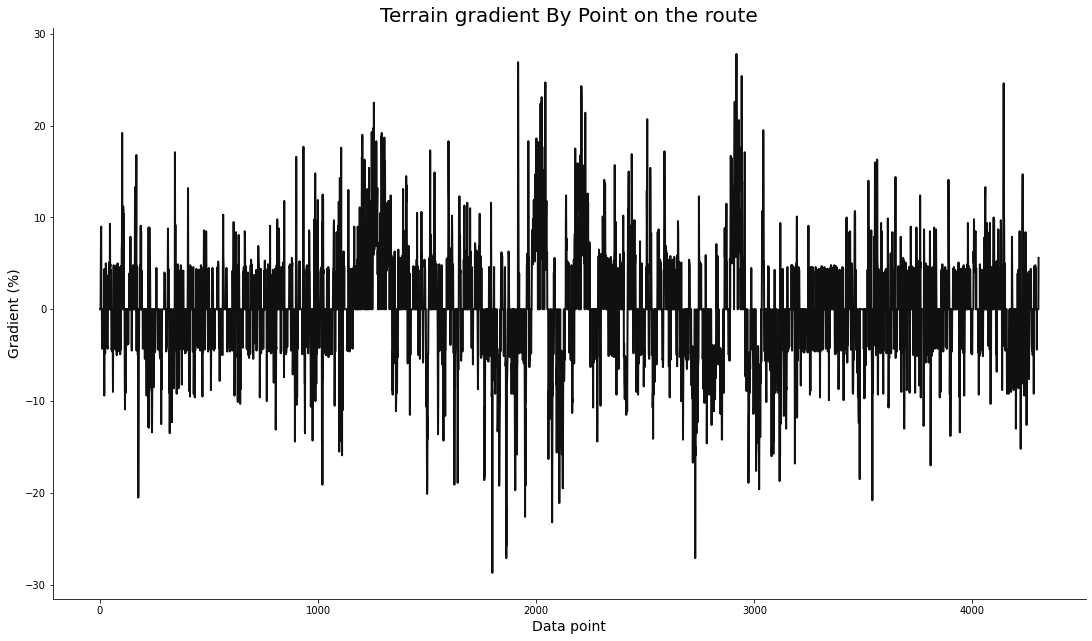

In [129]:
# gradient just from each step
grade_cap_high = 30
# km to miles
conversion_factor = 0.62137119
gradient_each_point =[np.nan]
for ind, row in df.iterrows():
    if ind == 0:
        continue
    grade = (row['elevation_change'] / ((row['distance']/conversion_factor*1000)+1))*100
    if abs(grade) > grade_cap_high :
        gradient_each_point.append(np.nan)
    else:
        gradient_each_point.append(np.round(grade,1))
    

plt.figure(figsize=(18.5, 10.5))
plt.title('Terrain gradient By Point on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(gradient_each_point)), gradient_each_point, lw=2, color='#101010');

In [130]:
# add to the dataframe
len(gradient_each_point)
df['gradient_each_point'] = gradient_each_point
df['gradient_each_point'] = df['gradient_each_point'].interpolate().fillna(0)


In [165]:
bin_labels_cut = ['Big Down', 'Little Down', 'Flat', 'Small Climb', 'Steep Climb']
bin_cuts=[-30, -15, -5, 5, 15, 30]
df['gradient_rating'] = pd.cut(df['gradient_each_point'],
                            bins=bin_cuts,
                            labels=bin_labels_cut)
df['gradient_rating'].value_counts()

Flat           3015
Small Climb     603
Little Down     565
Steep Climb      64
Big Down         57
Name: gradient_rating, dtype: int64

In [166]:
df.columns

Index(['time', 'latitude', 'longitude', 'elevation', 'pointxyz', 'distance',
       'mph', 'pace', 'sec_mile_pace', 'elevation_change', 'cum_elevation',
       'cum_distance', 'second', 'elapsed_time', 'step_feet', 'moving_time',
       'gradient_each_point', 'gradient_rating', 'gradient_range'],
      dtype='object')

In [167]:
# race = 'data//my_route_csv/Bull_Run_50M_2018.csv'
# df = pd.read_csv(race)

In [168]:
bins_ex = pd.IntervalIndex.from_tuples([
    (-30, -10),
    (-10, -5), 
    (-5, -3), 
    (-3, -1), 
    (-1, 0),
    (0, 1), 
    (1, 3), 
    (3, 5), 
    (5, 7), 
    (7, 10), 
    (10, 12), 
    (12, 15), 
    (15, 20)
], closed='left')
bins_ex
#gradient_each_point
df['gradient_range'] = pd.cut(df['gradient_each_point'], bins=bins_ex)
df.head()

,time,latitude,longitude,elevation,pointxyz,distance,mph,pace,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time,gradient_each_point,gradient_rating,gradient_range
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0,0.000000,0.0,0.0,0.000000,0,0:00:00,0.000000,0,0.0,Flat,"[0, 1)"
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,1.441224,0:41:37.876805,2497.876805,0.0,0.0,0.000400,1,0:00:01,2.113795,1,0.0,Flat,"[0, 1)"
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001189,4.281336,0:14:00.859022,840.859022,0.0,0.0,0.001590,2,0:00:02,6.279293,1,0.0,Flat,"[0, 1)"
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001182,4.254264,0:14:06.209826,846.209826,0.0,0.0,0.002771,3,0:00:03,6.239587,1,0.0,Flat,"[0, 1)"
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,7.421580,0:08:05.071912,485.071912,0.2,0.2,0.004833,4,0:00:04,10.884984,1,4.6,Flat,"[3, 5)"


In [169]:
df['gradient_range'].unique()

[[0, 1), [3, 5), [7, 10), [-5, -3), [-10, -5), ..., [15.0, 20.0), [10.0, 12.0), [-30.0, -10.0), [12.0, 15.0), NaN]
Length: 11
Categories (13, interval[int64, left]): [[-30, -10) < [-10, -5) < [-5, -3) < [-3, -1) ... [7, 10) < [10, 12) < [12, 15) < [15, 20)]

In [170]:
mygradient_details=[]
gradient='gradient_rating'

for gr_range in df[gradient].unique():
    subset = df[df[gradient]==gr_range]
    # Statistics
    total_distance = subset['distance'].sum()
    pct_of_total_run = (subset['distance'].sum()/df['distance'].sum())*100
    elevation_gain = subset[subset['elevation_change']>0]['elevation_change'].sum()
    elevation_lost = subset[subset['elevation_change']<0]['elevation_change'].sum()

    # Save Results
    mygradient_details.append({
        'gradient_range': gr_range,
        'total_distance': np.round(total_distance, 2),
        'pct_of_total_ride': np.round(pct_of_total_run, 2),
        'elevation_gain': np.round(elevation_gain, 2),
        'elevation_lost': np.round(np.abs(elevation_lost), 2)
    })


In [171]:
from numpy import sort
from pandas import Categorical, CategoricalDtype

# sorter = ['Down2', 'Down1', 'Flat', 'Climb1', 'Climb2']
mygradient_details_df = pd.DataFrame(mygradient_details)
# .sort_values(by=['gradient_range'])
# cat_type = CategoricalDtype(categories=sorter, ordered=True)
# mygradient_details_df.gradient_range = mygradient_details_df.gradient_range.astype(cat_type)


mygradient_details_df


,gradient_range,total_distance,pct_of_total_ride,elevation_gain,elevation_lost
0,Flat,6.16,74.33,102.4,114.4
1,Small Climb,0.95,11.49,172.0,0.0
2,Little Down,1.01,12.20,0.0,176.0
3,Steep Climb,0.08,0.92,34.2,0.0
4,Big Down,0.09,1.06,0.0,36.6


In [172]:
print(mygradient_details_df.gradient_range)

0           Flat
1    Small Climb
2    Little Down
3    Steep Climb
4       Big Down
Name: gradient_range, dtype: object


In [173]:
mygradient_details_df['total_distance'].sum()

8.290000000000001

In [174]:
colors = [
    '#0d46a0', '#2f3e9e', '#2195f2', '#4fc2f7',
    '#a5d6a7', '#66bb6a', '#fff59d', '#ffee58',
    '#ffca28', '#ffa000', '#ff6f00', '#f4511e', '#bf360c'
]
custom_text = [f'''<b>{gr}%</b> - {dst}miles''' for gr, dst in zip(
    mygradient_details_df['gradient_range'].astype('str'),
    mygradient_details_df['total_distance']
)]
custom_text

['<b>Flat%</b> - 6.16miles',
 '<b>Small Climb%</b> - 0.95miles',
 '<b>Little Down%</b> - 1.01miles',
 '<b>Steep Climb%</b> - 0.08miles',
 '<b>Big Down%</b> - 0.09miles']

In [175]:
import plotly.io as pio
fig = go.Figure(
    data=[go.Bar(
        x=mygradient_details_df['gradient_range'].astype(str),
        y=mygradient_details_df['total_distance'],
        marker_color=colors,
        text=custom_text
    )],
    layout=go.Layout(
        bargap=0,
        title='Gradient profile of a route',
        xaxis_title='Gradient range (%)',
        yaxis_title='Distance covered (miles)',
        autosize=False,
        width=1000,
        height=500,
        template='simple_white'
    )
)
fig.show()

In [176]:
df.head()

,time,latitude,longitude,elevation,pointxyz,distance,mph,pace,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time,gradient_each_point,gradient_rating,gradient_range
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0,0.000000,0.0,0.0,0.000000,0,0:00:00,0.000000,0,0.0,Flat,"[0, 1)"
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,1.441224,0:41:37.876805,2497.876805,0.0,0.0,0.000400,1,0:00:01,2.113795,1,0.0,Flat,"[0, 1)"
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001189,4.281336,0:14:00.859022,840.859022,0.0,0.0,0.001590,2,0:00:02,6.279293,1,0.0,Flat,"[0, 1)"
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001182,4.254264,0:14:06.209826,846.209826,0.0,0.0,0.002771,3,0:00:03,6.239587,1,0.0,Flat,"[0, 1)"
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,7.421580,0:08:05.071912,485.071912,0.2,0.2,0.004833,4,0:00:04,10.884984,1,4.6,Flat,"[3, 5)"


In [178]:
pace = []
distance_flat = df[df['gradient_rating'] == 'Flat']['distance'].sum()
time_flat = int(df[df['gradient_rating'] == 'Flat']['distance'].count())
print(distance_flat)
print(time_flat)
str(datetime.timedelta(seconds=time_flat))



6.160638791666665
3015


'0:50:15'

In [179]:

how_run_grade ={}
diff_grades = df['gradient_rating'].unique()
for i in diff_grades:
    dict_time_gradient = {}
    dict_time_gradient['distance'] = np.round(df[df['gradient_rating'] == i]['distance'].sum(),2)
    dict_time_gradient['time'] = int(df[df['gradient_rating'] == i]['distance'].count())
    dict_time_gradient['speed'] = np.round(dict_time_gradient['distance']/(dict_time_gradient['time']/60/60),2)
    dict_time_gradient['pace'] = str(datetime.timedelta(seconds=60/dict_time_gradient['speed']*60))

    how_run_grade[i] = dict_time_gradient

df_grade = pd.DataFrame.from_dict(how_run_grade)
df_grade


,Flat,Small Climb,Little Down,Steep Climb,Big Down
distance,6.16,0.95,1.01,0.08,0.09
time,3015,603,565,64,57
speed,7.36,5.67,6.44,4.5,5.68
pace,0:08:09.130435,0:10:34.920635,0:09:19.006211,0:13:20,0:10:33.802817


In [93]:
def make_mile_segments(row):
    return row['cum_distance']//1 +1
df['mile_num'] = df.apply(make_mile_segments, axis=1)

prev = df['second'][0]
conversion_factor = 0.62137119
grade_section_speed =[]
grade_pace =[]
mile_marker = []

for i in range(len(df)):
    
    unit_speed = df['mph'][i]
    if unit_speed == 0:
        unit_pace = 0
    else:
        unit_pace = str(datetime.timedelta(seconds=60/unit_speed*60))
    grade_section_speed.append(np.round(unit_speed,2))
    grade_pace.append(unit_pace)
    mile_marker.append(df['mile_num'][i])

In [180]:
d={'mile_number':mile_marker,'speed_mph':grade_section_speed,'pace':grade_pace,'gradient':gradient_each_point}
speed_grade = pd.DataFrame(data = d)
speed_grade.head()

,mile_number,speed_mph,pace,gradient
0,1.0,0.00,0,NaN
1,1.0,1.44,0:41:37.876805,0.0
2,1.0,4.28,0:14:00.859022,0.0
3,1.0,4.25,0:14:06.209826,0.0
4,1.0,7.42,0:08:05.071912,4.6


In [181]:
speed_grade[speed_grade['mile_number'] == 1]['gradient'].mean()

-0.5515021459227469

In [182]:
moving_analysis = speed_grade[speed_grade['speed_mph'] > 2]
moving_analysis.describe()

,mile_number,speed_mph,gradient
count,4259.000000,4259.000000,4257.000000
mean,4.672224,6.993592,0.052102
std,2.307625,1.475183,5.781619
min,1.000000,2.050000,-28.700000
25%,3.000000,6.090000,-4.200000
50%,5.000000,7.300000,0.000000
75%,7.000000,8.040000,4.200000
max,9.000000,10.000000,27.800000


In [99]:
import altair as alt
alt.data_transformers.disable_max_rows()

selection = alt.selection_multi(fields=['mile_number'])


scatter = alt.Chart(moving_analysis).mark_point(size=50).encode(
    alt.X("gradient"),
    alt.Y("speed_mph"),
    alt.Color("mile_number",
                legend = alt.Legend(
                    title = "Mile Number",
                    orient = 'left',
                    titleFontSize=15,
                    labelFontSize=13)
                ),
    opacity = alt.condition(selection, alt.value(1),alt.value(0))
).properties(
    height=350, width=500
).configure_axis(
    titleFontSize=20,
    labelFontSize=15
).add_selection(
    selection
)

scatter


alt.Chart(...)

In [100]:
source = speed_grade

brush = alt.selection(type='interval')

points = alt.Chart(source).mark_point().encode(
    x='gradient:N',
    y='speed_mph:Q',
    color=alt.condition(brush, 'mile_number:N', alt.value('lightgray'))
).properties(
    height=350, width=800
).add_selection(
    brush
)

bars = alt.Chart(source).mark_bar().encode(
    y='mile_number:N',
    color='mile_number:N',
    x='count(mile_number):Q'
).transform_filter(
    brush
)

points
# points & bars


alt.Chart(...)

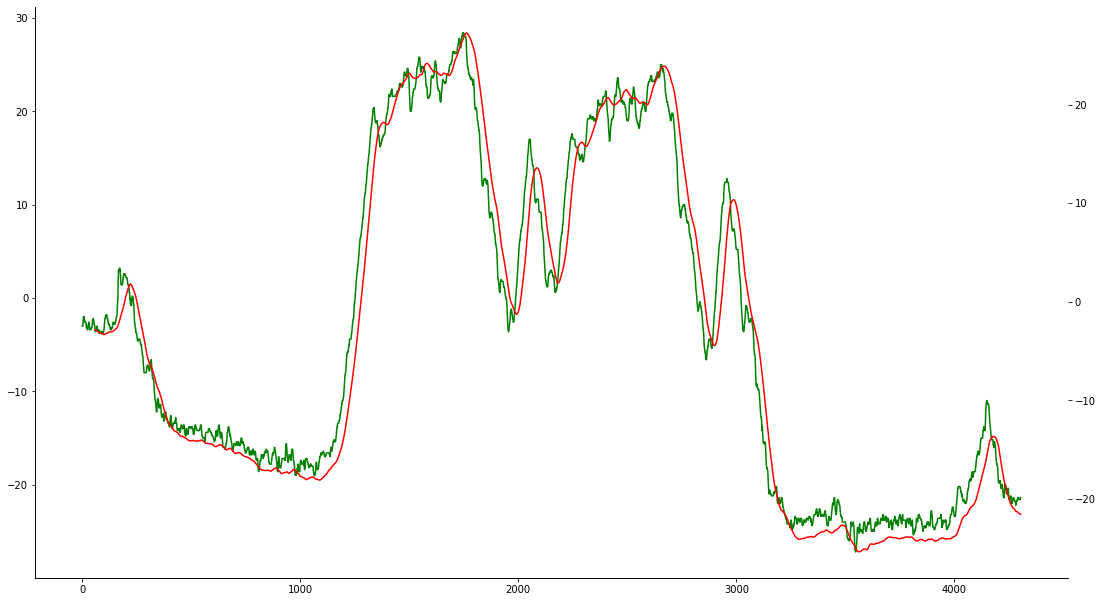

In [101]:
# Experiment with mean max and min on rolling elevation change
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index,df['elevation'], c='g')
points & bars
ax2.plot(df.index,df['elevation'].rolling(60).mean(), c='r')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).max()[0:2000], c='r')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).min()[0:2000], c='b')